# Figure 4.17 of Chapter 4

In [1]:
from summer2 import CompartmentalModel
from summer2.parameters import Parameter

import matplotlib.pyplot as plt

In [2]:
# Raw input parameters
latent_period = 8.
infectious_period = 7.
r0 = 13.
life_expectancy = 70.
population = 1e5
seed = 1.

# Derived parameters
beta = r0 / infectious_period
progression = 1. / latent_period
recovery = 1. / infectious_period
mortality = 1. / life_expectancy / 365.

In [3]:
def build_demog_model():
    # Create the SEIR model with demographic processes
    compartments = (
        "Susceptible", 
        "Pre-infectious", 
        "Infectious", 
        "Immune"
    )
    model = CompartmentalModel(
        times=(0, 25550.),
        compartments=compartments,
        infectious_compartments=["Infectious"],
    )
    model.set_initial_population(
        distribution={
            "Susceptible": population - seed, 
            "Infectious": seed,
        }
    )
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=beta,
        source="Susceptible", 
        dest="Pre-infectious"
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=progression,
        source="Pre-infectious", 
        dest="Infectious"
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=recovery, 
        source="Infectious", 
        dest="Immune",
    )
    model.add_universal_death_flows(
        "universal_death",
        death_rate=mortality,
    )
    model.request_output_for_flow(
        name="incidence", 
        flow_name="progression",
    )
    return model

In [4]:
seir_demog_model = build_demog_model()
seir_demog_model.add_replacement_birth_flow(
    "births",
    "Susceptible",
)
seir_demog_model.run()

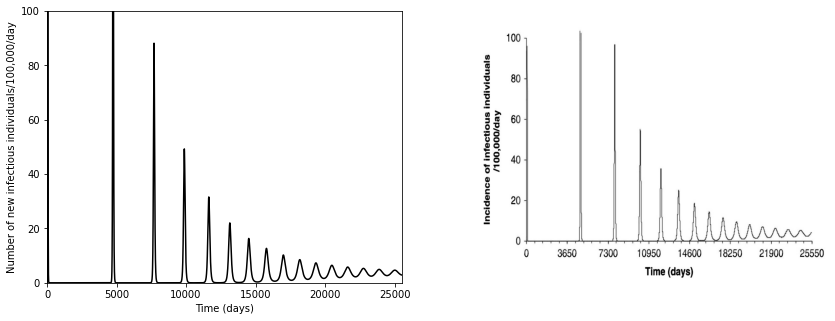

In [5]:
outputs = seir_demog_model.get_outputs_df()
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
left_ax.plot(seir_demog_model.times, seir_demog_model.get_derived_outputs_df()["incidence"], color="k")
left_ax.set_xlabel("Time (days)")
left_ax.set_xlim((0., 25550.))
left_ax.set_ylabel("Number of new infectious individuals/100,000/day")
left_ax.set_ylim((0, 100.))
image = plt.imread("./figures/fig_4_17.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

## Figure 4.19 a)

In [6]:
derived_outputs = seir_demog_model.get_derived_outputs_df()
derived_outputs.index = derived_outputs.index / 365.
outputs.index = outputs.index / 365.
output_props = outputs / population
outputs["R_n"] = r0 * output_props["Susceptible"]

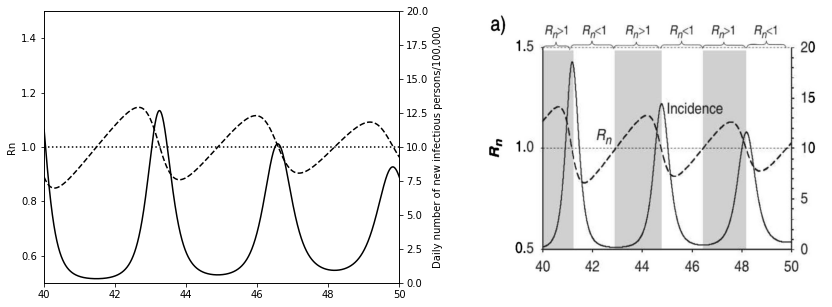

In [7]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

x_min = 40.
x_max = 50.

left_ax.plot(
    outputs.index,
    outputs["R_n"],
    color="k",
    linestyle="--",
)
left_ax.plot(
    (x_min, x_max),
    (1., 1.),
    color="k",
    linestyle=":",
)
left_ax.set_ylim(0.5, 1.5)
left_ax.set_xlim(x_min, x_max)
left_ax.set_ylabel("Rn")

twin_ax = left_ax.twinx()
twin_ax.plot(
    derived_outputs.index,
    derived_outputs["incidence"],
    color="k",
)
twin_ax.set_ylim(0., 20.)
twin_ax.set_ylabel("Daily number of new infectious persons/100,000")

image = plt.imread("./figures/fig_4_19a.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

## Figure 4.19 b)
Also covers all the information presented in Figure 4.20.

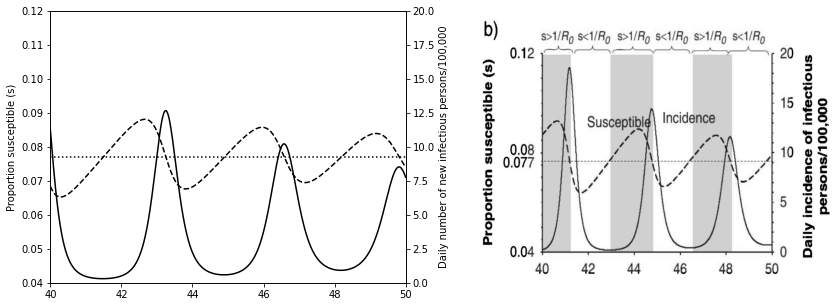

In [8]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

x_min = 40.
x_max = 50.

endemic_prop_susceptible = 1. / r0

left_ax.plot(
    output_props.index,
    output_props["Susceptible"],
    color="k",
    linestyle="--",
)
left_ax.plot(
    (x_min, x_max),
    (endemic_prop_susceptible, endemic_prop_susceptible),
    color="k",
    linestyle=":",
)
    
left_ax.set_ylim(0.04, 0.12)
left_ax.set_xlim(x_min, x_max)
left_ax.set_ylabel("Proportion susceptible (s)")

twin_ax = left_ax.twinx()
twin_ax.plot(
    derived_outputs.index,
    derived_outputs["incidence"],
    color="k",
)
twin_ax.set_ylim(0., 20.)
twin_ax.set_ylabel("Daily number of new infectious persons/100,000")

image = plt.imread("./figures/fig_4_19b.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

## Figure 4.19 c)

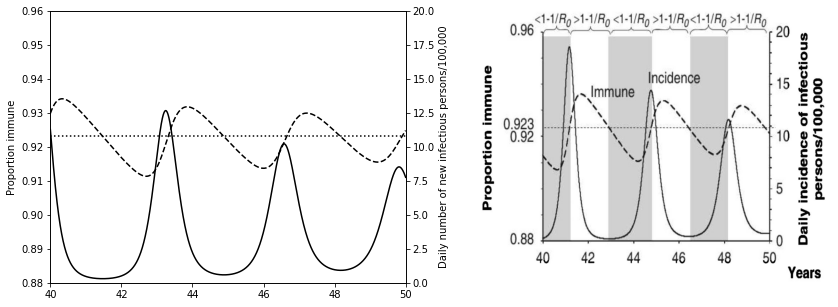

In [9]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

endemic_prop_immune = 1. - endemic_prop_susceptible

left_ax.plot(
    (x_min, x_max),
    (endemic_prop_immune, endemic_prop_immune),
    color="k",
    linestyle=":",
)

left_ax.plot(
    output_props.index,
    output_props["Immune"],
    color="k",
    linestyle="--",
)
left_ax.set_ylabel("Proportion immune")
left_ax.set_ylim(0.88, 0.96)

twin_ax = left_ax.twinx()
twin_ax.plot(
    derived_outputs.index,
    derived_outputs["incidence"],
    color="k",
)
twin_ax.set_ylabel("Daily number of new infectious persons/100,000")
left_ax.set_xlim(x_min, x_max)
twin_ax.set_ylim(0., 20.)

image = plt.imread("./figures/fig_4_19c.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

## Figure 4.26 a)

In [10]:
seir_variable_births_model = build_demog_model()
seir_variable_births_model.add_crude_birth_flow(
    "births",
    Parameter("crude_birth_rate") / 365.,
    "Susceptible",
)

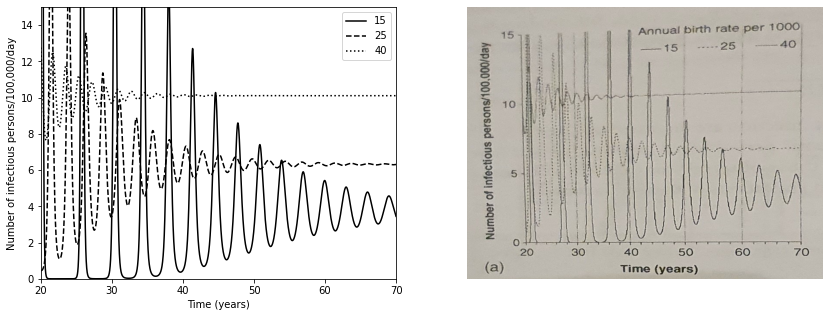

In [11]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
line_styles = ("-", "--", ":")
for r, rate in enumerate((0.015, 0.025, 0.04)):
    parameters = {
        "crude_birth_rate": rate,
    }
    seir_variable_births_model.run(parameters=parameters)
    outputs = seir_variable_births_model.get_outputs_df()
    population = outputs.sum(axis=1)
    incidence_rate = seir_variable_births_model.get_derived_outputs_df()["incidence"]
    incidence_rate /= population / 1e5
    incidence_rate.index = incidence_rate.index / 365.
    left_ax.plot(
        incidence_rate.index,
        incidence_rate,
        color="k",
        linestyle=line_styles[r],
        label=int(rate * 1000),
    )
left_ax.legend()
left_ax.set_xlabel("Time (years)")
left_ax.set_xlim((20., 70.))
left_ax.set_ylabel("Number of infectious persons/100,000/day")
left_ax.set_ylim((0., 15.))

image = plt.imread("./figures/fig_4_26.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");